**Прогнозирование индекса потребительских цен товаров и услуг по Российской Федерации**

*Индекс потребительских цен (ИПЦ)* - это индекс, измеряющий помесячную (поквартальную) динамику цен на потребительские товары и услуги. В первую очередь ИПЦ отражает уровень инфляции в стране и используется для его определения, а также для индексации заработных плат, социальных выплат, выплаты процентов, стоимости арендной платы, цен облигаций, товаров, работ, услуг закупаемых для государственных нужд и иных случаях в зависимости от поставленных задач.

Таким образом, понимание тренда развития ИПЦ и его прогноз могут быть использованы при расчете планируемых цен и построении бизнес планов.

В данной работе будут использованы открытые данные о ИПЦ с 2000 года, размещенные Федеральной службой государственной статистики на официальном сайте https://rosstat.gov.ru/.

***Загрузка используемых библиотек Python***

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#neural networks
from tensorflow.keras.models import Sequential#Последовательная архитектура (слой за слоем)=
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM  #Dense слои и нормализация батчей, и дропаут

**Загрузка данных**

In [2]:
# основные переменные для получения информации с сайта Росстата 
url = 'https://rosstat.gov.ru/statistics/price'
# будут использоваться индексы потребительских цен на товары и услуги по Российской Федерации (с 1991 г., помесячно)
name_index = '\n                Индексы потребительских цен на товары и услуги по Российской Федерации, месяцы (с 1991 г.)\n            '

In [3]:
# получение данных страницы с сайта Росстата
response_url = requests.get(url, headers={'User-Agent': 'Custom'}, timeout=10)

In [4]:
# получение ссылки на файл ИПЦ товаров и услуг с сайта Росстата
index_ipc_url = bs(response_url.text, "lxml").find(text = name_index).find_previous('a')['href']

In [5]:
# составление ссылки на требуемый файл
url_file = str("https://rosstat.gov.ru" + str(index_ipc_url))
url_file

'https://rosstat.gov.ru/storage/mediabank/ipc_mes-9.xlsx'

In [6]:
# чтение(скачивание) файла и преобразование в DataFrame
consumer_price_index = pd.read_excel(url_file, sheet_name='01').reset_index(drop=True)

In [7]:
# посмотрим что скачалось
consumer_price_index

,Индексы потребительских цен на товары и услуги1) по Российской Федерации в 1991-2023*)гг.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,К содержанию,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"на конец периода, в %",NaN,NaN
2,NaN,1991.0,1992.00,1993.00,1994.00,1995.00,1996.00,1997.00,1998.00,1999.00,...,2014.00,2015.00,2016.00,2017.00,2018.00,2019.00,2020.00,2021,2022.00,2023
3,к концу предыдущего месяца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,январь,106.2,345.30,125.80,117.90,117.77,104.11,102.34,101.51,108.38,...,100.59,103.85,100.96,100.62,100.31,101.01,100.40,100.67,100.99,100.84
5,февраль,104.8,138.00,124.70,110.82,111.02,102.79,101.54,100.89,104.13,...,100.70,102.22,100.63,100.22,100.21,100.44,100.33,100.78,101.17,100.46
6,март,106.3,129.90,120.10,107.41,108.94,102.80,101.43,100.64,102.79,...,101.02,101.21,100.46,100.13,100.29,100.32,100.55,100.66,107.61,100.37
7,апрель,163.5,121.70,118.70,108.49,108.47,102.16,100.96,100.38,103.03,...,100.90,100.46,100.44,100.33,100.38,100.29,100.83,100.58,101.56,100.38
8,май,103.0,111.90,118.10,106.91,107.93,101.60,100.94,100.50,102.22,...,100.90,100.35,100.41,100.37,100.38,100.34,100.27,100.74,100.12,100.31
9,июнь,101.2,119.10,119.90,106.00,106.66,101.17,101.10,100.08,101.91,...,100.62,100.19,100.36,100.61,100.49,100.04,100.22,100.69,99.65,100.37


In [8]:
# получение стартового значения индекса месяца
start_index = consumer_price_index.iloc[:,:1][consumer_price_index.iloc[:,:1] == 'январь']\
                                                                                    .dropna().index[0]

# получение кол-ва лет с текущим до 2000 года (включительно)
number_years = int(datetime.now().year) - 1999

# получение значений индексов по месячно и по годам
table_index = (consumer_price_index.iloc[:, -number_years:].loc[start_index:(start_index + 11)])\
                                                                               .reset_index(drop=True)

# замена названий в таблице (с 2000 года)
table_index.columns = [int(_) for _ in range(number_years)]

table_index

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,102.33,102.76,103.09,102.40,101.75,102.62,102.43,101.68,102.31,102.37,...,100.59,103.85,100.96,100.62,100.31,101.01,100.40,100.67,100.99,100.84
1,101.04,102.28,101.16,101.63,100.99,101.23,101.66,101.11,101.20,101.65,...,100.70,102.22,100.63,100.22,100.21,100.44,100.33,100.78,101.17,100.46
2,100.64,101.86,101.08,101.05,100.75,101.34,100.82,100.59,101.20,101.31,...,101.02,101.21,100.46,100.13,100.29,100.32,100.55,100.66,107.61,100.37
3,100.89,101.79,101.16,101.02,100.99,101.12,100.35,100.57,101.42,100.69,...,100.90,100.46,100.44,100.33,100.38,100.29,100.83,100.58,101.56,100.38
4,101.75,101.78,101.69,100.80,100.74,100.80,100.48,100.63,101.35,100.57,...,100.90,100.35,100.41,100.37,100.38,100.34,100.27,100.74,100.12,100.31
5,102.55,101.62,100.53,100.80,100.78,100.64,100.28,100.95,100.97,100.60,...,100.62,100.19,100.36,100.61,100.49,100.04,100.22,100.69,99.65,100.37
6,101.79,100.45,100.72,100.71,100.92,100.46,100.67,100.87,100.51,100.63,...,100.49,100.80,100.54,100.07,100.27,100.20,100.35,100.31,99.61,100.63
7,100.98,100.01,100.09,99.59,100.42,99.86,100.19,100.09,100.36,100.00,...,100.24,100.35,100.01,99.46,100.01,99.76,99.96,100.17,99.48,100.28
8,101.32,100.60,100.40,100.34,100.43,100.25,100.09,100.79,100.80,99.97,...,100.65,100.57,100.17,99.85,100.16,99.84,99.93,100.6,100.05,100.87
9,102.11,101.09,101.07,101.00,101.14,100.55,100.28,101.64,100.91,100.00,...,100.82,100.74,100.43,100.20,100.35,100.13,100.43,101.11,100.18,NaN


In [9]:
# составление списка индексов в виде одномерного массива (вектора)
list_index = (pd.concat([table_index[_] for _ in range(number_years)])).reset_index(drop=True).dropna()
list_index

0      102.33
1      101.04
2      100.64
3      100.89
4      101.75
        ...  
280    100.31
281    100.37
282    100.63
283    100.28
284    100.87
Length: 285, dtype: object

**Подготовка датасета**

In [10]:
# определение даты построения прогнозной модели
current_date = date.today()

# создание списка дат помесячно начиная с 2000 года 
list_date = []
starting_date = date(2000, 1, 1)
while starting_date <= current_date:
    list_date.append(starting_date)
    starting_date += relativedelta(months=1)

# посмотрим на последние 5 элементов списка
list_date[-5:]

[datetime.date(2023, 6, 1),
 datetime.date(2023, 7, 1),
 datetime.date(2023, 8, 1),
 datetime.date(2023, 9, 1),
 datetime.date(2023, 10, 1)]

In [11]:
# создание основного датасета
df = pd.DataFrame(columns=['Date', 'IPC'], data = list(zip(list_date[:len(list_index):], \
                                                   list_index.astype('float32'))))
df.tail()

,Date,IPC
280,2023-05-01,100.309998
281,2023-06-01,100.370003
282,2023-07-01,100.629997
283,2023-08-01,100.279999
284,2023-09-01,100.870003


In [12]:
# исключаются индексы строк и заменяются датами
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
# посмотрим на данные за прошедший год
df[(current_date - relativedelta(months=12)) : current_date]

,IPC
Date,
2022-11-01,100.370003
2022-12-01,100.779999
2023-01-01,100.839996
2023-02-01,100.459999
2023-03-01,100.370003
2023-04-01,100.379997
2023-05-01,100.309998
2023-06-01,100.370003
2023-07-01,100.629997


**Визуализация данных**

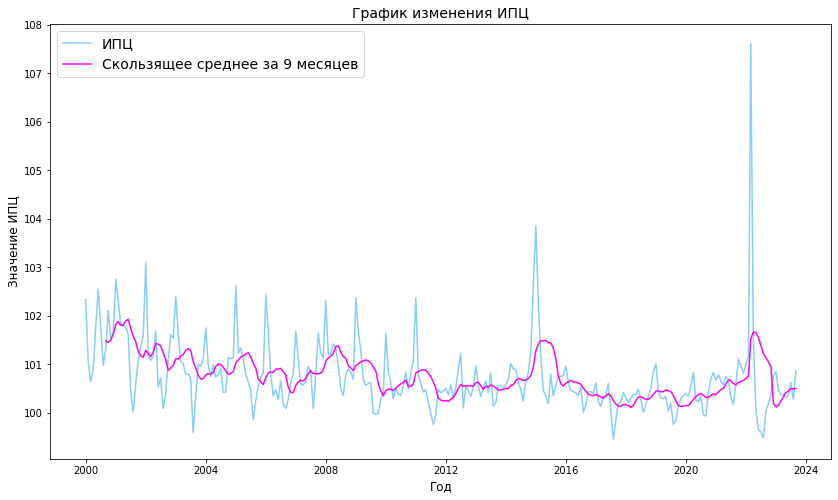

In [13]:
# построение графика динамики изменения ИПЦ по месячно начиная с 2000 года
plt.figure(figsize = (14, 8))
plt.plot(df, label = 'ИПЦ', color = 'LightSkyBlue') # steelblue slategray gainsboro darkgray LightSkyBlue
plt.plot(df.rolling(window = 9).mean(), label = 'Скользящее среднее за 9 месяцев', color = 'magenta')
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlabel('Год', fontsize = 12)
plt.ylabel('Значение ИПЦ', fontsize = 12)
plt.title('График изменения ИПЦ', fontsize = 14)
plt.show()

In [14]:
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(df['IPC'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.012807085529583855


Как видно из графика до 2011 года наблюдается определенная сезонность (различные по значению волны имеющие примерно равные промежутки времени), но с 2012 года такая закономерность на графике отсутствует. Вероятность нулевой гипотезы (временной ряд не стационарен) расчитанная тестом Дики-Фуллера менее 5%, таким образом временной ряд стационарен (тренд и сезонность отсутствуют), что также следует из построеного графика.

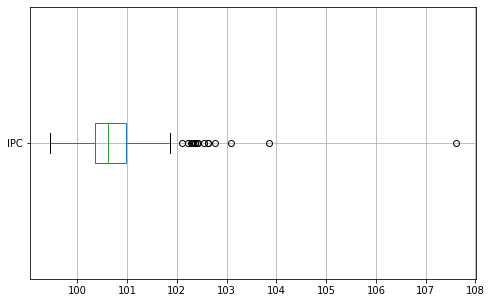

In [15]:
# построим на "ящик с усами"
df.boxplot(column=['IPC'], vert = False, figsize=(8, 5))
plt.show()

In [16]:
# получение общих статистик по датасету
df.describe()

,IPC
count,285.000000
mean,100.764807
std,0.751446
min,99.459999
25%,100.349998
50%,100.610001
75%,100.989998
max,107.610001


In [17]:
# количество элементов которые превышают 101.9 (16 будут заменены из 285 (5,61%)
print(df.loc[df['IPC'] > 101.9])
len(df.loc[df['IPC'] > 101.9])

                   IPC
Date                  
2000-01-01  102.330002
2000-06-01  102.550003
2000-10-01  102.110001
2001-01-01  102.760002
2001-02-01  102.279999
2002-01-01  103.089996
2003-01-01  102.400002
2005-01-01  102.620003
2006-01-01  102.430000
2008-01-01  102.309998
2009-01-01  102.370003
2011-01-01  102.370003
2014-12-01  102.620003
2015-01-01  103.849998
2015-02-01  102.220001
2022-03-01  107.610001


16

Как видно из графиков набор данных обладает значительными выбросами (случайными колебаниями), что может привести к искажениям и ухудшению прогноза. Также видно, что основная масса таких выбросов приходится на начало и конец года, что вероятнее всего связано с формированием бюджета страны, выплатами крупных компаний, также ряд выбросов привязаны к определенным историческим событиям. Общее количество таких событий 16 из 285 т.е. 5,61 процента. Исходя из этого в целях повышения качества предсказания заменим выбросы на максимальные значения из генеральной совокупности, что позволит сохранить их как максимальные, но при этом все значения будут находится в одном диапазоне. При получение значений предсказаний близких к 102.00 необходимо понимать, что это значение может быть и выше.

In [18]:
# сохранение первоначального набора данных
df_original = df.copy()

In [32]:
# df = df_original.copy()

In [19]:
# замена значений выбросов на максимально возможное значение
df.loc[df['IPC'] > 101.9] = 101.9

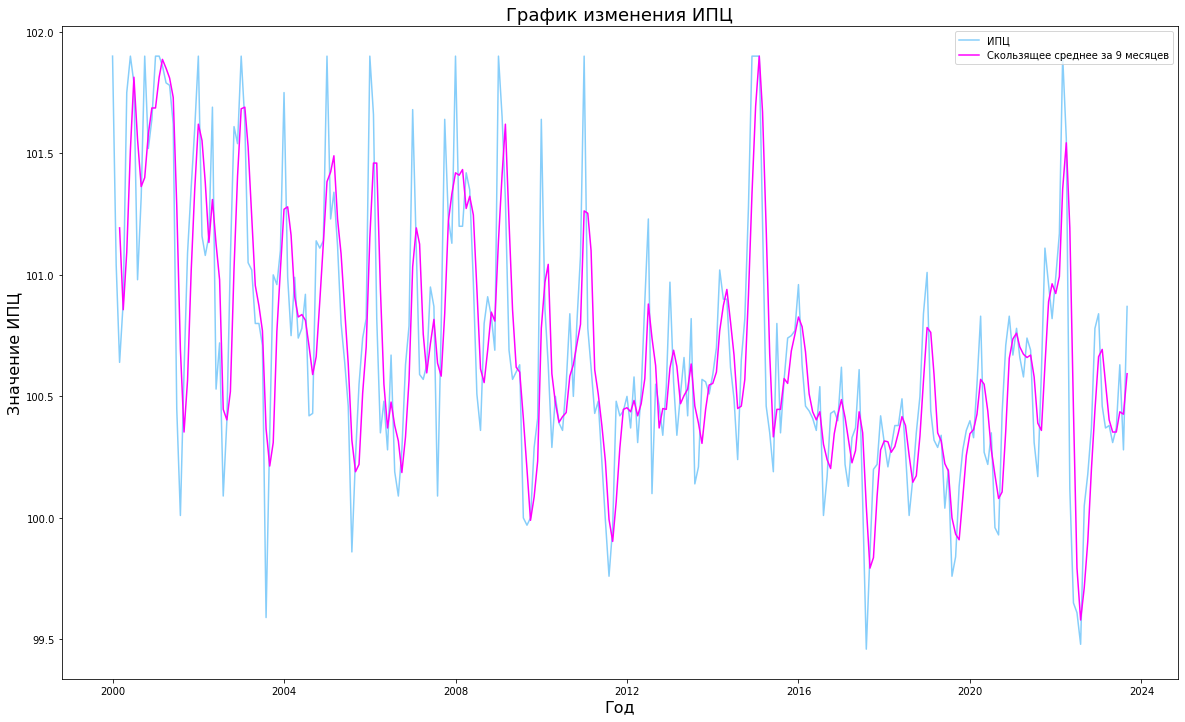

In [20]:
# построение графика динамики изменения ИПЦ по месячно начиная с 2000 года (после замены выбросов)
# зададим размер графика
plt.figure(figsize = (20,12))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(df, label = 'ИПЦ', color = 'LightSkyBlue') # steelblue   slategray  gainsboro
plt.plot(df.rolling(window = 3).mean(), label = 'Скользящее среднее за 9 месяцев', color = 'magenta')

    
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('Год', fontsize = 16)
plt.ylabel('Значение ИПЦ', fontsize = 16)
plt.title('График изменения ИПЦ', fontsize = 18)
 
# выведем обе кривые на одном графике
# plt.show()
plt.legend(loc='upper right')

<AxesSubplot:>

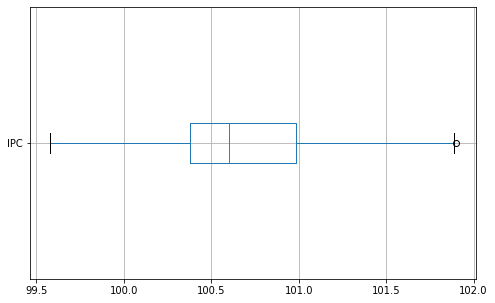

In [21]:
# посмотрим на "ящик с усами" СРЕДНЕЕ
df.rolling(window = 3).mean().boxplot(column=['IPC'], vert = False, figsize=(8, 5))

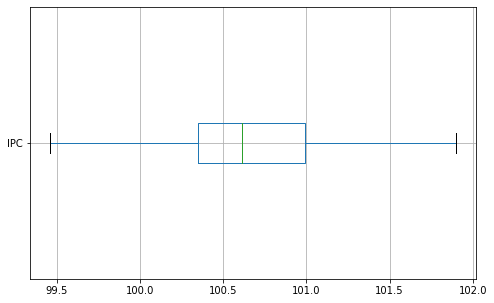

In [22]:
# посмотрим на "ящик с усами"
df.boxplot(column=['IPC'], vert = False, figsize=(8, 5))
plt.show()

In [23]:
# получение общих статистик по датасету
df.describe()

,IPC
count,285.000000
mean,100.710351
std,0.539453
min,99.459999
25%,100.349998
50%,100.610001
75%,100.989998
max,101.900000


In [84]:
df_ppp = df.rolling(window = 3).mean()[2:]

In [26]:
# df.index = pd.to_datetime(df.index)

Во-вторых, введем важное понятие временного лага (lag), т.е. запаздывания по сравнению с заданным периодом.

In [24]:
# смещение данных для предсказания
forecast_out = int(math.ceil(0.01 * len(df))) # forcasting out 5% of the entire dataset
print(forecast_out)

3


In [25]:
# устанавливаю смещение в 3 месяцев
forecast_out = 3
df['label'] = df['IPC'].shift(-forecast_out)

In [26]:
df.tail()

,IPC,label
Date,,
2023-05-01,100.309998,100.279999
2023-06-01,100.370003,100.870003
2023-07-01,100.629997,NaN
2023-08-01,100.279999,NaN
2023-09-01,100.870003,NaN


In [27]:
scaler = StandardScaler()
X_row = np.array(df.drop(['label'], 1))
scaler.fit(X_row)
X_row_scaler = scaler.transform(X_row)

C:\Users\user\AppData\Local\Temp\ipykernel_6748\1471771713.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_row = np.array(df.drop(['label'], 1))


In [28]:
X_Predictions = X_row_scaler[-forecast_out:]
X = X_row_scaler[:-forecast_out]

In [32]:
X_Predictions

array([[-0.14921566],
       [-0.79915917],
       [ 0.29647203]])

In [29]:
df.dropna(inplace=True)
y = np.array(df['label'])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train.shape

(225, 1)

In [51]:
def predict_models(X_train, X_test, y_train, y_test):
    #
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_confidence = lr.score(X_test, y_test)
    #
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_confidence = rf.score(X_test, y_test)
    #
    rg = Ridge()
    rg.fit(X_train, y_train)
    rg_confidence = rg.score(X_test, y_test)
    #
    svr = SVR()
    svr.fit(X_train, y_train)
    svr_confidence = svr.score(X_test, y_test)
    # model perceptron
    
    # Build the model 
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    # input_shape = (X_train.shape[1], 1)
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units = 1))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error') # mean_squared_error accuracy

    # Fitting the model to the Training set
    history_vr = model.fit(X_train.astype('float32'), y_train.astype('float32'), epochs = 200, batch_size = 4, validation_split=.20)

        
    score = [lr_confidence, rf_confidence, rg_confidence, svr_confidence, history_vr.history['val_loss'][-1]]
    
    
    return lr, rf, rg, svr, model, score  

In [52]:
lr, rf, rg, svr, model, score = predict_models(X_train, X_test, y_train, y_test)
score

Epoch 1/200
45/45 [==============================] - 3s 17ms/step - loss: 10114.1279 - val_loss: 10062.5938
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 9886.8350 - val_loss: 9531.6553
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 8704.6348 - val_loss: 7580.1641
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 6531.4429 - val_loss: 5566.3535
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 4969.5693 - val_loss: 4430.4141
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 4041.7402 - val_loss: 3707.3167
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 3450.8486 - val_loss: 3168.6421
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 2978.7617 - val_loss: 2731.1023
Epoch 9/200
45/45 [==============================] - 0s 3ms/step - loss: 2569.0989 - val_loss: 2362.7959
Epoch 10/200
45/45 [==============================] 

Epoch 81/200
45/45 [==============================] - 0s 3ms/step - loss: 30.3004 - val_loss: 0.2371
Epoch 82/200
45/45 [==============================] - 0s 3ms/step - loss: 24.3110 - val_loss: 0.2881
Epoch 83/200
45/45 [==============================] - 0s 3ms/step - loss: 27.2169 - val_loss: 0.2946
Epoch 84/200
45/45 [==============================] - 0s 3ms/step - loss: 27.1954 - val_loss: 0.3290
Epoch 85/200
45/45 [==============================] - 0s 3ms/step - loss: 25.2955 - val_loss: 0.2609
Epoch 86/200
45/45 [==============================] - 0s 3ms/step - loss: 21.5007 - val_loss: 0.2984
Epoch 87/200
45/45 [==============================] - 0s 3ms/step - loss: 21.9418 - val_loss: 0.3333
Epoch 88/200
45/45 [==============================] - 0s 3ms/step - loss: 26.4369 - val_loss: 0.3633
Epoch 89/200
45/45 [==============================] - 0s 3ms/step - loss: 29.8651 - val_loss: 0.2861
Epoch 90/200
45/45 [==============================] - 0s 3ms/step - loss: 22.9164 - val_los

In [53]:
score

[0.2166569130615722,
 -0.1822230848976767,
 0.21583259884346362,
 0.18314304911047208,
 0.6190006136894226]

In [54]:
# Предсказание
forecast_set = model.predict(X_Predictions)
forecast_set

1/1 [==============================] - 1s 669ms/step


array([[100.05116],
       [100.00809],
       [100.0848 ]], dtype=float32)

In [55]:
[df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]

[Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-09-01 00:00:00')]

In [114]:
df.tail()

,IPC,label
Date,,
2023-02-01,100.459999,100.309998
2023-03-01,100.370003,100.370003
2023-04-01,100.379997,100.629997
2023-05-01,100.309998,100.279999
2023-06-01,100.370003,100.870003


In [56]:
next_date = [df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]


In [57]:
next_date

[Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-09-01 00:00:00')]

In [58]:
len(df.index)

282

In [60]:
df.loc[df.tail(1).index[0]]

IPC      100.370003
label    100.870003
Name: 2023-06-01, dtype: float64

In [61]:
forecast_set = model.predict(X_Predictions) 
next_date = [df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]
df['Forecast'] = np.nan
for i in range(forecast_out):
    df.loc[next_date[i]] = [np.nan, np.nan, forecast_set[i][0]]
    #df.loc[df.tail(1).index[0]] = [next_date[i], np.nan, np.nan, forecast_set[i][0]]
    # df.loc[next_date[i]] = forecast_set[i]

1/1 [==============================] - 0s 14ms/step


In [66]:
list(zip(next_date, forecast_set_lr))

[(datetime.date(2023, 10, 1), 100.72380018672142),
 (datetime.date(2023, 11, 1), 100.66876740587192),
 (datetime.date(2023, 12, 1), 100.76153797898222)]

In [120]:
df.tail()

,IPC,label,Forecast
Date,,,
2023-05-01,100.309998,100.279999,NaN
2023-06-01,100.370003,100.870003,NaN
2023-07-01,NaN,NaN,98.450439
2023-08-01,NaN,NaN,98.469025
2023-09-01,NaN,NaN,98.441879


In [62]:
df_rez = df.copy()

In [63]:
df = df_rez.copy()

In [64]:
next_date = [df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]
df.tail()

,IPC,label,Forecast
Date,,,
2023-05-01,100.309998,100.279999,NaN
2023-06-01,100.370003,100.870003,NaN
2023-07-01,NaN,NaN,100.308434
2023-08-01,NaN,NaN,100.286400
2023-09-01,NaN,NaN,100.334175


In [59]:
[np.nan for _ in range(4)]

[nan, nan, nan, nan]

In [60]:
pd.DataFrame(columns=['Forecast_lr', 'Forecast_rf', 'Forecast_rg', 'Forecast_svr'], data = [np.nan for _ in range(4)])

ValueError: Shape of passed values is (4, 1), indices imply (4, 4)

In [ ]:
def predict_models(X_Predictions):
    # создание датасета функции
    df_def = 
    df_def['Forecast_lr'] = np.nan
    df['Forecast_rf'] = np.nan
    df['Forecast_rg'] = np.nan
    df['Forecast_svr'] = np.nan
    
    pd.DataFrame(columns=['Forecast_lr', 'Forecast_rf', 'Forecast_rg', 'Forecast_svr'], data = list(zip(list_date[:len(list_index):], \
                                                   list_index.astype('float32'))))
    
    
    # Линейная регрессия
    forecast_set_lr = lr.predict(X_Predictions) 
    next_date = [df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]
    for i in range(forecast_out):
        df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], forecast_set_lr[i]]
        
    forecast_set_rf = rf.predict(X_Predictions) 
    for i in range(forecast_out):
        df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], forecast_set_rf[i]]
    
    forecast_set_rg = rg.predict(X_Predictions) 
    for i in range(forecast_out):
        df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], df['Forecast_rf'][-1-i], forecast_set_rg[i]]
    
    forecast_set_svr = svr.predict(X_Predictions) 
    for i in range(forecast_out):
        df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], df['Forecast_rf'][-1-i], df['Forecast_rg'][-1-i], forecast_set_svr[i]]
    

In [65]:
forecast_set_lr = lr.predict(X_Predictions) 
next_date = [df.tail(1).index[0]+relativedelta(months=_) for _ in range(1, forecast_out+1)]
df['Forecast_lr'] = np.nan
for i in range(forecast_out):
    df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], forecast_set_lr[i]]

In [66]:
forecast_set_rf = rf.predict(X_Predictions) 
df['Forecast_rf'] = np.nan
for i in range(forecast_out):
    df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], forecast_set_rf[i]]

In [67]:
forecast_set_rg = rg.predict(X_Predictions) 
df['Forecast_rg'] = np.nan
for i in range(forecast_out):
    df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], df['Forecast_rf'][-1-i], forecast_set_rg[i]]

In [68]:
forecast_set_svr = svr.predict(X_Predictions) 
df['Forecast_svr'] = np.nan
for i in range(forecast_out):
    df.iloc[-1-i] = [np.nan, np.nan, df['Forecast'][-1-i], df['Forecast_lr'][-1-i], df['Forecast_rf'][-1-i], df['Forecast_rg'][-1-i], forecast_set_svr[i]]

In [ ]:
282    100.63
283    100.28
284    100.87

In [69]:
df.tail()

,IPC,label,Forecast,Forecast_lr,Forecast_rf,Forecast_rg,Forecast_svr
Date,,,,,,,
2023-05-01,100.309998,100.279999,NaN,NaN,NaN,NaN,NaN
2023-06-01,100.370003,100.870003,NaN,NaN,NaN,NaN,NaN
2023-07-01,NaN,NaN,100.308434,100.736376,100.674620,100.736245,100.656546
2023-08-01,NaN,NaN,100.286400,100.620652,101.194588,100.621057,100.520107
2023-09-01,NaN,NaN,100.334175,100.689301,100.412450,100.689388,100.565284


In [140]:
df.iloc[-4] = [df['IPC'][-4], df['label'][-4], df['IPC'][-4], df['IPC'][-4]]

In [135]:
df.tail()

,IPC,label,Forecast,Forecast_lr
Date,,,,
2023-05-01,100.309998,100.279999,NaN,NaN
2023-06-01,100.370003,100.870003,NaN,NaN
2023-07-01,NaN,NaN,98.450439,100.761162
2023-08-01,NaN,NaN,98.469025,100.666452
2023-09-01,NaN,NaN,98.441879,100.722635


In [141]:
df.tail()

,IPC,label,Forecast,Forecast_lr
Date,,,,
2023-05-01,100.309998,100.279999,NaN,NaN
2023-06-01,100.370003,100.870003,100.370003,100.370003
2023-07-01,NaN,NaN,98.450439,100.761162
2023-08-01,NaN,NaN,98.469025,100.666452
2023-09-01,NaN,NaN,98.441879,100.722635


In [59]:
last_date = date(2023, 6, 1) #datetime.strptime('01.06.2023',"%d.%m.%Y") 
last_unix = last_date.timestamp() 
one_day = 2592000 # 86400 *30 *15 
next_unix = last_unix + one_day 
forecast_set = model.predict(X_Predictions) 
df['Forecast'] = np.nan
for i in forecast_set:
    next_date = datetime.fromtimestamp(next_unix)#.strptime("%d.%m.%Y")
    next_unix += 2592000 # 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

AttributeError: 'datetime.date' object has no attribute 'timestamp'

In [66]:
df.tail(20)

,IPC,label,Forecast
Date,,,
2022-01-01,100.989998,101.559998,NaN
2022-02-01,101.169998,100.120003,NaN
2022-03-01,107.610001,99.650002,NaN
2022-04-01,101.559998,99.610001,NaN
2022-05-01,100.120003,99.480003,NaN
2022-06-01,99.650002,100.050003,NaN
2022-07-01,99.610001,100.180000,NaN
2022-08-01,99.480003,100.370003,NaN
2022-09-01,100.050003,100.779999,NaN


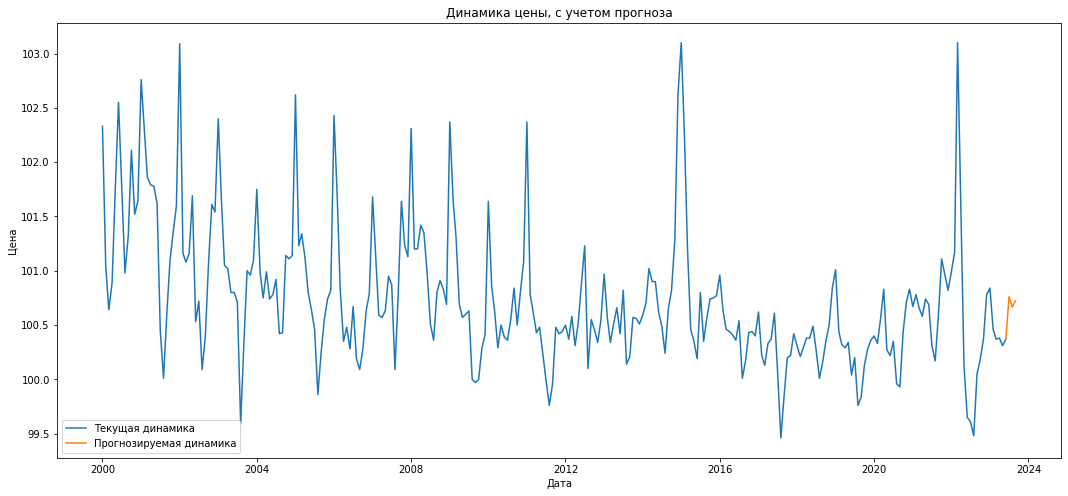

In [142]:
plt.figure(figsize=(18, 8))
df['IPC'].plot(label='Текущая динамика')
df['Forecast_lr'].plot(label='Прогнозируемая динамика')
plt.legend(loc=3)
plt.title('Динамика цены, с учетом прогноза')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

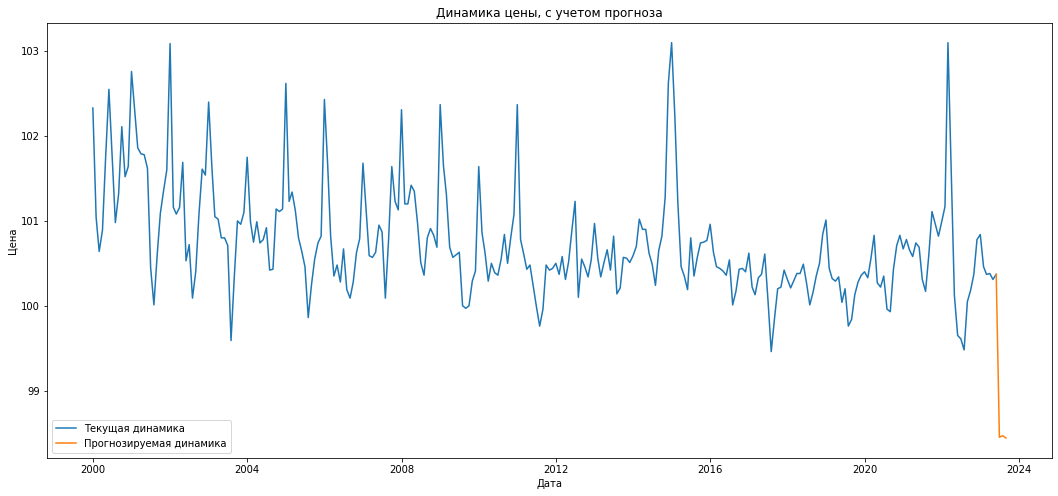

In [143]:
plt.figure(figsize=(18, 8))
df['IPC'].plot(label='Текущая динамика')
df['Forecast'].plot(label='Прогнозируемая динамика')
plt.legend(loc=3)
plt.title('Динамика цены, с учетом прогноза')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

In [ ]:
# сохраню модели
filepath_model = r'D:/Documents/model_row_model_vrem_ryd.pkl'
pickle.dump(model, open(filepath_model, 'wb'))

In [77]:
start_index = int((pd.DataFrame(data=consumer_price_index.iloc[:, 0:1].values)[0]) \
                      [pd.DataFrame(data=consumer_price_index.iloc[:, 0:1].values)[0] == 'январь'].index[0])

# получение кол-ва лет с текущим до 2014
number_years = int(datetime.now().year) - 2013

# получение значений индексов по месячно и по годам
table_index = (consumer_price_index.iloc[:, -number_years:].loc[start_index:(start_index + 11)]).reset_index(
    drop=True)
# замена названий в таблице
table_index.columns = [int(_) for _ in range(number_years)]
# составление списка индексов
list_index = (pd.concat([table_index[_] for _ in range(number_years)])).reset_index(drop=True).dropna()
# вычитание из индексов 100 и фильтр от новых к старым 2014 года
list_index = list_index.subtract(pd.Series(100, index=range(len(list_index))))[::-1]
# последовательное прибавление предыдущих значений
list_index = pd.Series([round(sum(list_index[:(i + 1)]), 4) for i in range(len(list_index))])
# прибавление ко всем значеним 100
list_index = list_index.subtract(pd.Series(-100, index=range(len(list_index))))
# деление всех значений на 100
list_index = round(list_index/pd.Series([100] * len(list_index)), 4)
# получение списка месяцев и лет
u = []
# m = ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12')
m = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12')
y = [str(_) for _ in range(2014, 2014 + number_years, 1)]
for j in y:
    for x in m: u.append(x + '_' + j)
u = pd.Series(u[:len(list_index)][::-1])

if datetime.strptime(u[0], '%m_%Y').month < current_date.month:
    number_months = current_date.month - datetime.strptime(u[0], '%m_%Y').month
    month = current_date.strftime("%m").replace('0', '')
    u = pd.concat([pd.Series([tt.strftime("%m").replace('0', '') + tt.strftime("_%Y") for tt in
                    [(current_date - pd.DateOffset(months=m)) for m in range(number_months)]]), u]).reset_index(drop=True)
    list_index = pd.concat([pd.Series([1]*number_months), list_index]).reset_index(drop=True)
data = dict(zip(u, list_index))

In [78]:
data

{'9_2023': 1.0,
 '8_2023': 1.0028,
 '7_2023': 1.0091,
 '6_2023': 1.0128,
 '5_2023': 1.0159,
 '4_2023': 1.0197,
 '3_2023': 1.0234,
 '2_2023': 1.028,
 '1_2023': 1.0364,
 '12_2022': 1.0442,
 '11_2022': 1.0479,
 '10_2022': 1.0497,
 '9_2022': 1.0502,
 '8_2022': 1.045,
 '7_2022': 1.0411,
 '6_2022': 1.0376,
 '5_2022': 1.0388,
 '4_2022': 1.0544,
 '3_2022': 1.1305,
 '2_2022': 1.1422,
 '1_2022': 1.1521,
 '12_2021': 1.1603,
 '11_2021': 1.1699,
 '10_2021': 1.181,
 '9_2021': 1.187,
 '8_2021': 1.1887,
 '7_2021': 1.1918,
 '6_2021': 1.1987,
 '5_2021': 1.2061,
 '4_2021': 1.2119,
 '3_2021': 1.2185,
 '2_2021': 1.2263,
 '1_2021': 1.233,
 '12_2020': 1.2413,
 '11_2020': 1.2484,
 '10_2020': 1.2527,
 '9_2020': 1.252,
 '8_2020': 1.2516,
 '7_2020': 1.2551,
 '6_2020': 1.2573,
 '5_2020': 1.26,
 '4_2020': 1.2683,
 '3_2020': 1.2738,
 '2_2020': 1.2771,
 '1_2020': 1.2811,
 '12_2019': 1.2847,
 '11_2019': 1.2875,
 '10_2019': 1.2888,
 '9_2019': 1.2872,
 '8_2019': 1.2848,
 '7_2019': 1.2868,
 '6_2019': 1.2872,
 '5_2019': 

In [ ]:
df = {"date": u,
        "list_index": list_index}
df = pd.concat(df, axis=1)
print("Таблица с данными по контракту")
df.to_excel(r'D:\Documents\eis_contract\prob\my_index.xlsx', index=False)

In [30]:
registry_entries_list.find_all('div', {'class': ['btn btn-icon btn-white btn-br btn-sm']})

AttributeError: ResultSet object has no attribute 'find_all'. You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

In [13]:
table_execution_сontract = pd.read_html(((registry_entries_list).parent.find_next_siblings()[0]).prettify(),
                                            skiprows=0)[0]

AttributeError: ResultSet object has no attribute 'parent'. You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

In [ ]:
consumer_price_index = pd.read_excel('https://rosstat.gov.ru/storage/mediabank/Ipc_mes-6.xlsx',
                                         sheet_name='01').reset_index(drop=True)

In [ ]:
   start_index = int((pd.DataFrame(data=consumer_price_index.iloc[:, 0:1].values)[0]) \
                          [pd.DataFrame(data=consumer_price_index.iloc[:, 0:1].values)[0] == 'январь'].index[0])

    # получение кол-ва лет с текущим до 2014
    number_years = int(datetime.now().year) - 2013

    # получение значений индексов по месячно и по годам
    table_index = (consumer_price_index.iloc[:, -number_years:].loc[start_index:(start_index + 11)]).reset_index(
        drop=True)
    # замена названий в таблице
    table_index.columns = [int(_) for _ in range(number_years)]
    # составление списка индексов
    list_index = (pd.concat([table_index[_] for _ in range(number_years)])).reset_index(drop=True).dropna()
    # вычитание из индексов 100 и фильтр от новых к старым 2014 года
    list_index = list_index.subtract(pd.Series(100, index=range(len(list_index))))[::-1]
    # последовательное прибавление предыдущих значений
    list_index = pd.Series([round(sum(list_index[:(i + 1)]), 4) for i in range(len(list_index))])
    # прибавление ко всем значеним 100
    list_index = list_index.subtract(pd.Series(-100, index=range(len(list_index))))
    # деление всех значений на 100
    list_index = round(list_index/pd.Series([100] * len(list_index)), 4)
    # получение списка месяцев и лет
    u = []
    # m = ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12')
    m = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12')
    y = [str(_) for _ in range(2014, 2014 + number_years, 1)]
    for j in y:
        for x in m: u.append(x + '_' + j)
    u = pd.Series(u[:len(list_index)][::-1])

    if datetime.strptime(u[0], '%m_%Y').month < current_date.month:
        number_months = current_date.month - datetime.strptime(u[0], '%m_%Y').month
        month = current_date.strftime("%m").replace('0', '')
        u = pd.concat([pd.Series([tt.strftime("%m").replace('0', '') + tt.strftime("_%Y") for tt in
                        [(current_date - pd.DateOffset(months=m)) for m in range(number_months)]]), u]).reset_index(drop=True)
        list_index = pd.concat([pd.Series([1]*number_months), list_index]).reset_index(drop=True)
    data = dict(zip(u, list_index))
    df = {"date": u,
            "list_index": list_index}
    df = pd.concat(df, axis=1)
    print("Таблица с данными по контракту")
    df.to_excel(r'D:\Documents\eis_contract\prob\my_index.xlsx', index=False)

In [1]:
LOCAL_DATA_PATH_TRAIN = 'D:/data/2023.04.14/train.csv'
LOCAL_DATA_PATH_TEST = 'D:/data/2023.04.14/test.csv'

##import

In [2]:
#общие
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#ML 
from sklearn.linear_model import LinearRegression #лдинейная регрессия
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor  #регрессия на основе метода ближайших соседей
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor 
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

#metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

sns.set_style('darkgrid')

##работа с данными

In [3]:
data = pd.read_csv(LOCAL_DATA_PATH_TRAIN) #, index_col = 0
data.head()

,row_id,user_id,timestamp,gate_id
0,0,18,2022-07-29 09:08:54,7
1,1,18,2022-07-29 09:09:54,9
2,2,18,2022-07-29 09:09:54,9
3,3,18,2022-07-29 09:10:06,5
4,4,18,2022-07-29 09:10:08,5


##Смотрим что загрузилось

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   row_id     37518 non-null  int64 
 1   user_id    37518 non-null  int64 
 2   timestamp  37518 non-null  object
 3   gate_id    37518 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [6]:
data.shape

(37518, 4)

###смотрим пропуски

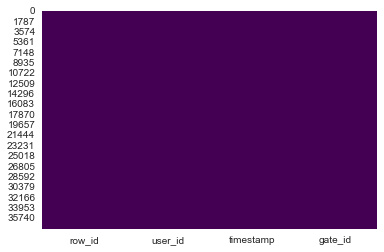

In [7]:
sns.heatmap(data.isna(), cmap = 'viridis', cbar = False)
plt.show()

In [8]:
data['timestamp'].value_counts()

2022-10-20 16:31:33    4
2022-09-19 19:05:22    3
2022-10-24 14:23:28    3
2022-12-08 09:14:24    3
2022-09-21 13:53:08    3
                      ..
2022-09-08 09:34:54    1
2022-09-08 09:34:20    1
2022-09-08 09:33:59    1
2022-09-08 09:33:57    1
2022-09-28 20:23:17    1
Name: timestamp, Length: 34068, dtype: int64

###Заменяем Not available на NaN

###пробуем преобразовать признаки во float

In [ ]:
for col in data.columns.to_list():
  try:
    data[col] = data[col].astype('float64')
    print('УСПЕШНОЕ преобразование для : ', col )
  except:
    print('ОШИБКА преобразования для : ', col )

УСПЕШНОЕ преобразование для :  Property Id
ОШИБКА преобразования для :  Property Name
ОШИБКА преобразования для :  Parent Property Id
ОШИБКА преобразования для :  Parent Property Name
ОШИБКА преобразования для :  BBL - 10 digits
ОШИБКА преобразования для :  NYC Borough, Block and Lot (BBL) self-reported
ОШИБКА преобразования для :  NYC Building Identification Number (BIN)
ОШИБКА преобразования для :  Address 1 (self-reported)
ОШИБКА преобразования для :  Address 2
ОШИБКА преобразования для :  Postal Code
ОШИБКА преобразования для :  Street Number
ОШИБКА преобразования для :  Street Name
ОШИБКА преобразования для :  Borough
УСПЕШНОЕ преобразование для :  DOF Gross Floor Area
ОШИБКА преобразования для :  Primary Property Type - Self Selected
ОШИБКА преобразования для :  List of All Property Use Types at Property
ОШИБКА преобразования для :  Largest Property Use Type
УСПЕШНОЕ преобразование для :  Largest Property Use Type - Gross Floor Area (ft²)
ОШИБКА преобразования для :  2nd Largest 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   row_id     37518 non-null  int64 
 1   user_id    37518 non-null  int64 
 2   timestamp  37518 non-null  object
 3   gate_id    37518 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


##Обработка пропусков

In [9]:
#функция принимает датафрейм и возвращает датафрейм с пропусками с сорнтировкой по убыванию
def get_missing_values(df):
  #всего пропусков
  mis_val = df.isna().sum()
  #считаем в прцоентах
  mis_val_percents = df.isna().sum() / df.shape[0] * 100
  #объединение пропусков
  mis_val_table = pd.concat([mis_val, mis_val_percents], axis = 1)

  #создаём датафрейм
  mis_val_df = mis_val_table.rename(columns = {0 : 'кол-во пропусков', 
                                               1 : '% пропусков'})
  mis_val_df_sorted = mis_val_df[mis_val_df.iloc[:, 1] != 0 ].sort_values('% пропусков',
                                                                          ascending = False)
  #выводим статистику

  print(f'Датасет содержит : {df.shape[1]} колонок')
  print(f'из них {mis_val_df_sorted.shape[0]} колонок имеют пропуски')
  
  return mis_val_df_sorted

In [10]:
get_missing_values(data)

Датасет содержит : 4 колонок
из них 0 колонок имеют пропуски


,кол-во пропусков,% пропусков


###удаляем признаким с пропусками

##изучаем целевую переменную


row_id	user_id	timestamp	gate_id

In [11]:
data['row_id'].value_counts()

0        1
25023    1
25007    1
25008    1
25009    1
        ..
12507    1
12508    1
12509    1
12510    1
37517    1
Name: row_id, Length: 37518, dtype: int64

<AxesSubplot:>

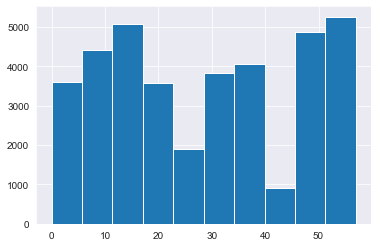

In [13]:
data['user_id'].hist()

<AxesSubplot:>

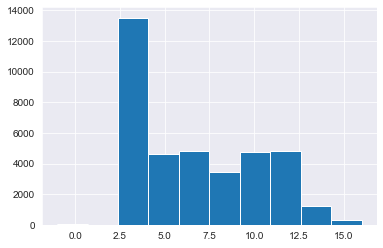

In [15]:
data['gate_id'].hist()

In [16]:
data['gate_id'].isna().sum() / data.shape[0] * 100

0.0

In [25]:
data['timestamp'][0][5:7]

'07'

In [46]:
data['timestamp'][0]

'2022-07-29 09:08:54'

In [48]:
# datetime.datetime.strptime(data['timestamp'][0], '%Y-%m-%d %H:%M:%S.%f')
datetime.datetime.strptime(data['timestamp'][0], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2022, 7, 29, 9, 8, 54)

'2022-07-29 09:08:54'

In [8]:
data['date_time'] = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data['timestamp']]

In [13]:
data['weekday'] = [i.weekday() for i in data['date_time']]

In [46]:
data['weekday_worker'] = [i.weekday() for i in data['date_time']]

In [49]:
# Замена значение на определенное
data.loc[(data['weekday_worker'] < 5 ), (2)] = int(0)
data.loc[(data['weekday_worker'] > 5 ), (2)] = int(1)

In [5]:
# data['year'] = [int(i[0:4]) for i in data['timestamp']]
# data['month'] = [int(i[5:7]) for i in data['timestamp']]
data['date_month'] = [int(i[8:10]) for i in data['timestamp']]
data['hour'] = [int(i[11:13]) for i in data['timestamp']]
data['minutes'] = [int(i[14:16]) for i in data['timestamp']]

In [50]:
data.head()

,row_id,user_id,timestamp,gate_id,year,month,date_month,hour,minutes,date_time,weekday,weekday_worker,2
0,0,18,2022-07-29 09:08:54,7,2022,7,29,9,8,2022-07-29 09:08:54,4,4,0.0
1,1,18,2022-07-29 09:09:54,9,2022,7,29,9,9,2022-07-29 09:09:54,4,4,0.0
2,2,18,2022-07-29 09:09:54,9,2022,7,29,9,9,2022-07-29 09:09:54,4,4,0.0
3,3,18,2022-07-29 09:10:06,5,2022,7,29,9,10,2022-07-29 09:10:06,4,4,0.0
4,4,18,2022-07-29 09:10:08,5,2022,7,29,9,10,2022-07-29 09:10:08,4,4,0.0


<AxesSubplot:>

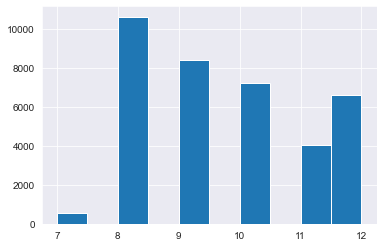

In [42]:
data['month'].hist()

<AxesSubplot:>

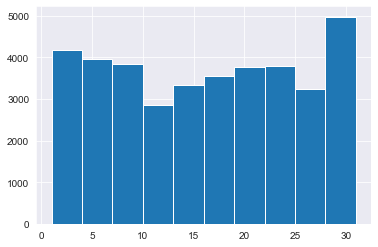

In [43]:
data['date_month'].hist()

<AxesSubplot:>

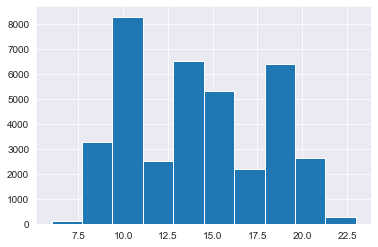

In [44]:
data['hour'].hist()

<AxesSubplot:>

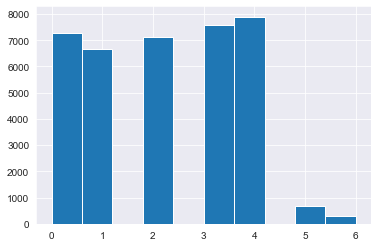

In [34]:
data['weekday'].hist()

In [51]:
data['user_id'].value_counts()

37    2262
55    2238
6     2013
12    1953
19    1793
15    1756
18    1578
47    1341
53    1311
1     1299
33    1285
11    1281
49    1275
0     1250
39    1144
32    1076
54    1070
9     1034
50     994
29     990
3      989
48     743
14     696
17     677
27     603
35     601
46     502
57     497
24     416
42     359
26     316
34     284
23     261
25     247
40     242
31     191
56     137
41     124
43     124
20     115
22      96
28      64
45      57
7       49
36      48
2       39
8       29
10      17
38      13
5       10
30      10
52       5
21       5
44       4
51       3
4        2
Name: user_id, dtype: int64

In [55]:
data['month'].value_counts()

8     10639
9      8394
10     7238
12     6642
11     4042
7       563
Name: month, dtype: int64

In [56]:
data['date_month'].value_counts()

5     1850
29    1758
2     1525
26    1476
1     1468
19    1447
22    1421
30    1391
16    1335
7     1329
21    1304
15    1303
9     1294
23    1267
8     1226
3     1181
4     1151
12    1134
18    1108
24    1103
28    1103
17    1101
27    1029
13    1024
20    1017
14    1008
6      965
10     934
11     790
25     747
31     729
Name: date_month, dtype: int64

In [59]:
data['date_time'][1] - data['date_time'][0]

Timedelta('0 days 00:01:00')

In [11]:
data['date_time'][1].weekday()

4

In [10]:
data['date_time'][1]

Timestamp('2022-07-29 09:09:54')

In [23]:
# Фильтруем по условию (оставляю только картофель)
data.loc[data['timestamp'].str.contains("2022-11-04")== True]

,row_id,user_id,timestamp,gate_id,year,month,date_month,hour,minutes,date_time,weekday
27630,27630,17,2022-11-04 09:20:52,9,2022,11,4,9,20,2022-11-04 09:20:52,4
27631,27631,17,2022-11-04 09:20:52,9,2022,11,4,9,20,2022-11-04 09:20:52,4
27632,27632,17,2022-11-04 09:21:04,5,2022,11,4,9,21,2022-11-04 09:21:04,4
27633,27633,17,2022-11-04 09:21:06,5,2022,11,4,9,21,2022-11-04 09:21:06,4
27634,27634,17,2022-11-04 09:21:21,10,2022,11,4,9,21,2022-11-04 09:21:21,4
...,...,...,...,...,...,...,...,...,...,...,...
27877,27877,33,2022-11-04 20:50:26,11,2022,11,4,20,50,2022-11-04 20:50:26,4
27878,27878,33,2022-11-04 20:50:48,6,2022,11,4,20,50,2022-11-04 20:50:48,4
27879,27879,33,2022-11-04 20:50:49,6,2022,11,4,20,50,2022-11-04 20:50:49,4
27880,27880,33,2022-11-04 20:50:57,9,2022,11,4,20,50,2022-11-04 20:50:57,4


In [45]:
data.loc[data['timestamp'].str.contains("2022-11-18")== True]

,row_id,user_id,timestamp,gate_id,year,month,date_month,hour,minutes,date_time,weekday
28716,28716,26,2022-11-18 08:09:03,15,2022,11,18,8,9,2022-11-18 08:09:03,4
28717,28717,26,2022-11-18 08:13:30,15,2022,11,18,8,13,2022-11-18 08:13:30,4
28718,28718,3,2022-11-18 08:40:22,7,2022,11,18,8,40,2022-11-18 08:40:22,4
28719,28719,3,2022-11-18 08:41:20,9,2022,11,18,8,41,2022-11-18 08:41:20,4
28720,28720,3,2022-11-18 08:41:20,9,2022,11,18,8,41,2022-11-18 08:41:20,4
...,...,...,...,...,...,...,...,...,...,...,...
29003,29003,0,2022-11-18 21:29:26,4,2022,11,18,21,29,2022-11-18 21:29:26,4
29004,29004,0,2022-11-18 21:29:34,9,2022,11,18,21,29,2022-11-18 21:29:34,4
29005,29005,0,2022-11-18 21:29:34,9,2022,11,18,21,29,2022-11-18 21:29:34,4
29006,29006,57,2022-11-18 21:32:16,4,2022,11,18,21,32,2022-11-18 21:32:16,4


In [33]:
data.loc[data['weekday'] < 6]

,row_id,user_id,timestamp,gate_id,year,month,date_month,hour,minutes,date_time,weekday
0,0,18,2022-07-29 09:08:54,7,2022,7,29,9,8,2022-07-29 09:08:54,4
1,1,18,2022-07-29 09:09:54,9,2022,7,29,9,9,2022-07-29 09:09:54,4
2,2,18,2022-07-29 09:09:54,9,2022,7,29,9,9,2022-07-29 09:09:54,4
3,3,18,2022-07-29 09:10:06,5,2022,7,29,9,10,2022-07-29 09:10:06,4
4,4,18,2022-07-29 09:10:08,5,2022,7,29,9,10,2022-07-29 09:10:08,4
...,...,...,...,...,...,...,...,...,...,...,...
37513,37513,6,2022-12-31 20:38:56,11,2022,12,31,20,38,2022-12-31 20:38:56,5
37514,37514,6,2022-12-31 20:39:22,6,2022,12,31,20,39,2022-12-31 20:39:22,5
37515,37515,6,2022-12-31 20:39:23,6,2022,12,31,20,39,2022-12-31 20:39:23,5
37516,37516,6,2022-12-31 20:39:31,9,2022,12,31,20,39,2022-12-31 20:39:31,5


https://rosstat.gov.ru/storage/mediabank/cpi_ru.pdf


Нильсен, Эйлин. Практический анализ временных рядов: прогнозирование со статистикой и машинное обучение. : Пер. с англ. — СПб. : ООО “Диалектика”, 2021. — 544 с. : ил. — Парал. тит. англ. ISBN 978-5-907365-04-9 (рус.)